In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
import torch.utils.data as data
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [258]:
class NumpyDataset(data.Dataset):
    def __init__(self, array):
        super().__init__()
        self.tensor = torch.tensor(array, device=device)

    def __len__(self):
        return len(self.tensor)

    def __getitem__(self, index):
        return self.tensor[index]

In [408]:
class RealNVP(nn.Module):
    def __init__(self, save_path='best_model.pth', dataset_name="Moons", masks=None, prior=None, learning_rate=1e-4, decay=None, device=None):
        super(RealNVP, self).__init__()
        self.save_path = save_path
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if masks is None:
            self.binary_mask = torch.tensor([[0, 1], [1, 0]] * 3, device=self.device).float()
        else:
            self.binary_mask = masks
        self.prior = prior if prior else distributions.MultivariateNormal(torch.zeros(2, device=self.device), torch.eye(2, device=self.device))
        self.mask = nn.Parameter(self.binary_mask, requires_grad=False)
        self.lr = learning_rate
        self.decay = decay

        if dataset_name == "Moons":
            conv_s = lambda: nn.Sequential(
                nn.Linear(2, 256),
                nn.LeakyReLU(),
                nn.Linear(256, 256),
                nn.LeakyReLU(),
                nn.Linear(256, 2),
                nn.Tanh()
            )

            conv_t = lambda: nn.Sequential(
                nn.Linear(2, 256),
                nn.LeakyReLU(),
                nn.Linear(256, 256),
                nn.LeakyReLU(),
                nn.Linear(256, 2)
            )

        elif ((dataset_name == "Circles") or (dataset_name == "Gaussian Art")):
            conv_s =  lambda: nn.Sequential(
                nn.Linear(in_features=2, out_features=32),
                nn.LeakyReLU(),
                nn.Linear(in_features=32, out_features=32), nn.LeakyReLU(),
                nn.Linear(in_features=32, out_features=2)
            )

            conv_t = lambda: nn.Sequential(
                nn.Linear(in_features=2, out_features=32), nn.LeakyReLU(),
                nn.Linear(in_features=32, out_features=32), nn.LeakyReLU(),
                nn.Linear(in_features=32, out_features=2)
            )

        else:
            raise ValueError("Dataset name not recognized. Please use 'Moons', 'Circles' or 'Gaussian Art'.")

        self.s = torch.nn.ModuleList([conv_s() for _ in range(len(self.binary_mask))])
        self.t = torch.nn.ModuleList([conv_t() for _ in range(len(self.binary_mask))])
        self.to(self.device)

    def apply_transformation(self, x, is_reverse=False):
        b_mask = self.mask
        if is_reverse == False: # f : x -> z
            log_det_J = x.new_zeros(x.shape[0])
            for i in reversed(range(len(self.t))):
                s = self.s[i](b_mask[i] * x) * (1-b_mask[i])
                t = self.t[i](b_mask[i] * x) * (1-b_mask[i])
                x = (1 - b_mask[i]) * (x - t) * torch.exp(-s) + (b_mask[i] * x)
                log_det_J -= s.sum(dim=1)
            z = x
            return z, log_det_J
        else: # g = f^(-1) : z -> x
            z = x
            for i in range(len(self.t)):
                s = self.s[i](b_mask[i] * z) * (1-b_mask[i])
                t = self.t[i](b_mask[i] * z) * (1-b_mask[i])
                z = (1 - b_mask[i]) * (z * torch.exp(s) + t) + (b_mask[i] * z)
            x = z
            return x

    def log_prob(self,x):
        z, logp = self.apply_transformation(x, is_reverse=False)
        return self.prior.log_prob(z) + logp

    def sample(self, batchSize):
        z = self.prior.sample((batchSize, 1))
        x = self.apply_transformation(z, is_reverse=True)
        return x

    def fit(self, train_loader: DataLoader, n_epochs: int, restore_best: bool = True):
        best_loss = torch.inf
        optimizer = torch.optim.Adam([p for p in self.parameters() if p.requires_grad==True], lr=self.lr)
        if self.decay:
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[n_epochs//10, n_epochs//4,  n_epochs//2], gamma=self.decay)
        for epoch in range(n_epochs):
            self.train()
            for x in train_loader:
                optimizer.zero_grad()
                loss = -self.log_prob(x).mean()
                loss.backward(retain_graph=True)
                optimizer.step()

            if self.decay:
                scheduler.step()
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(self.state_dict(), self.save_path)
            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

        if restore_best:
            self.load_state_dict(torch.load(self.save_path))

In [382]:
seed = 42
train_data = NumpyDataset(datasets.make_moons(n_samples=200000, noise=0.05)[0].astype(np.float32))
test_data = NumpyDataset(datasets.make_moons(n_samples=1000, noise=0.05)[0].astype(np.float32))

#train_data = datasets.make_moons(n_samples=1000, noise=0.1)[0].astype(np.float32)
#test_data = datasets.make_moons(n_samples=500, noise=0.1)[0].astype(np.float32)

train_loader = data.DataLoader(train_data, batch_size=100, shuffle=False)
test_loader = data.DataLoader(test_data, batch_size=100)

In [383]:
torch.manual_seed(seed)
n_epochs = 1
learning_rate = 1e-4
flow = RealNVP(learning_rate=learning_rate, device='cuda', save_path='best_model_moon.pth')
flow.fit(train_loader, n_epochs, restore_best=False)

Epoch 0, Loss: 0.5241570472717285


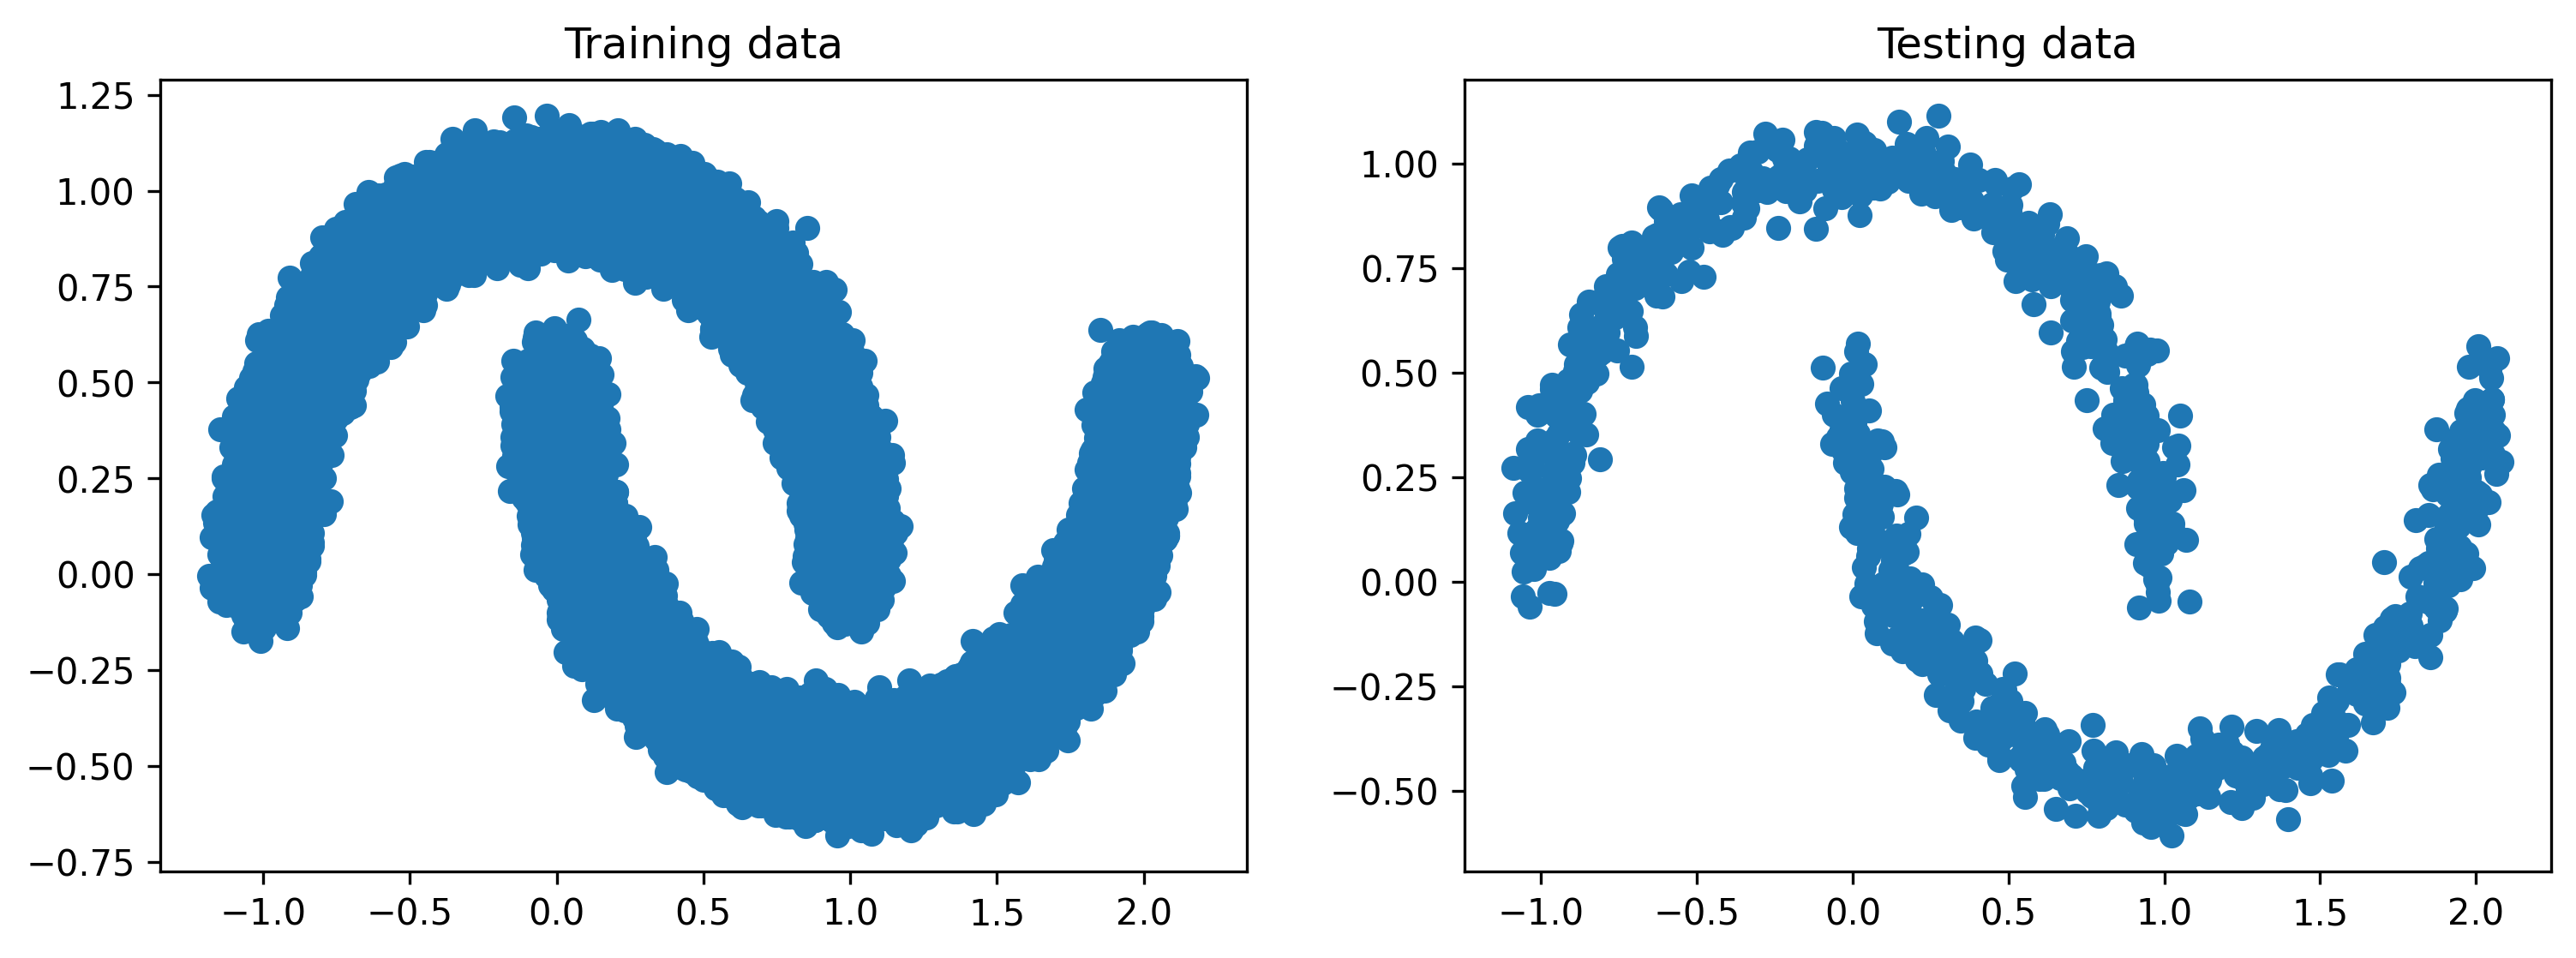

In [317]:
_, axes = plt.subplots(1,2,figsize=(12,4))
x,y = train_loader.dataset.tensor[:,0].cpu(), train_loader.dataset.tensor[:,1].cpu()
_ = axes[0].scatter(x,y)
_ = axes[0].set_title('Training data')

x,y = test_loader.dataset.tensor[:,0].cpu(), test_loader.dataset.tensor[:,1].cpu()
_ = axes[1].scatter(x,y)
_ = axes[1].set_title('Testing data')

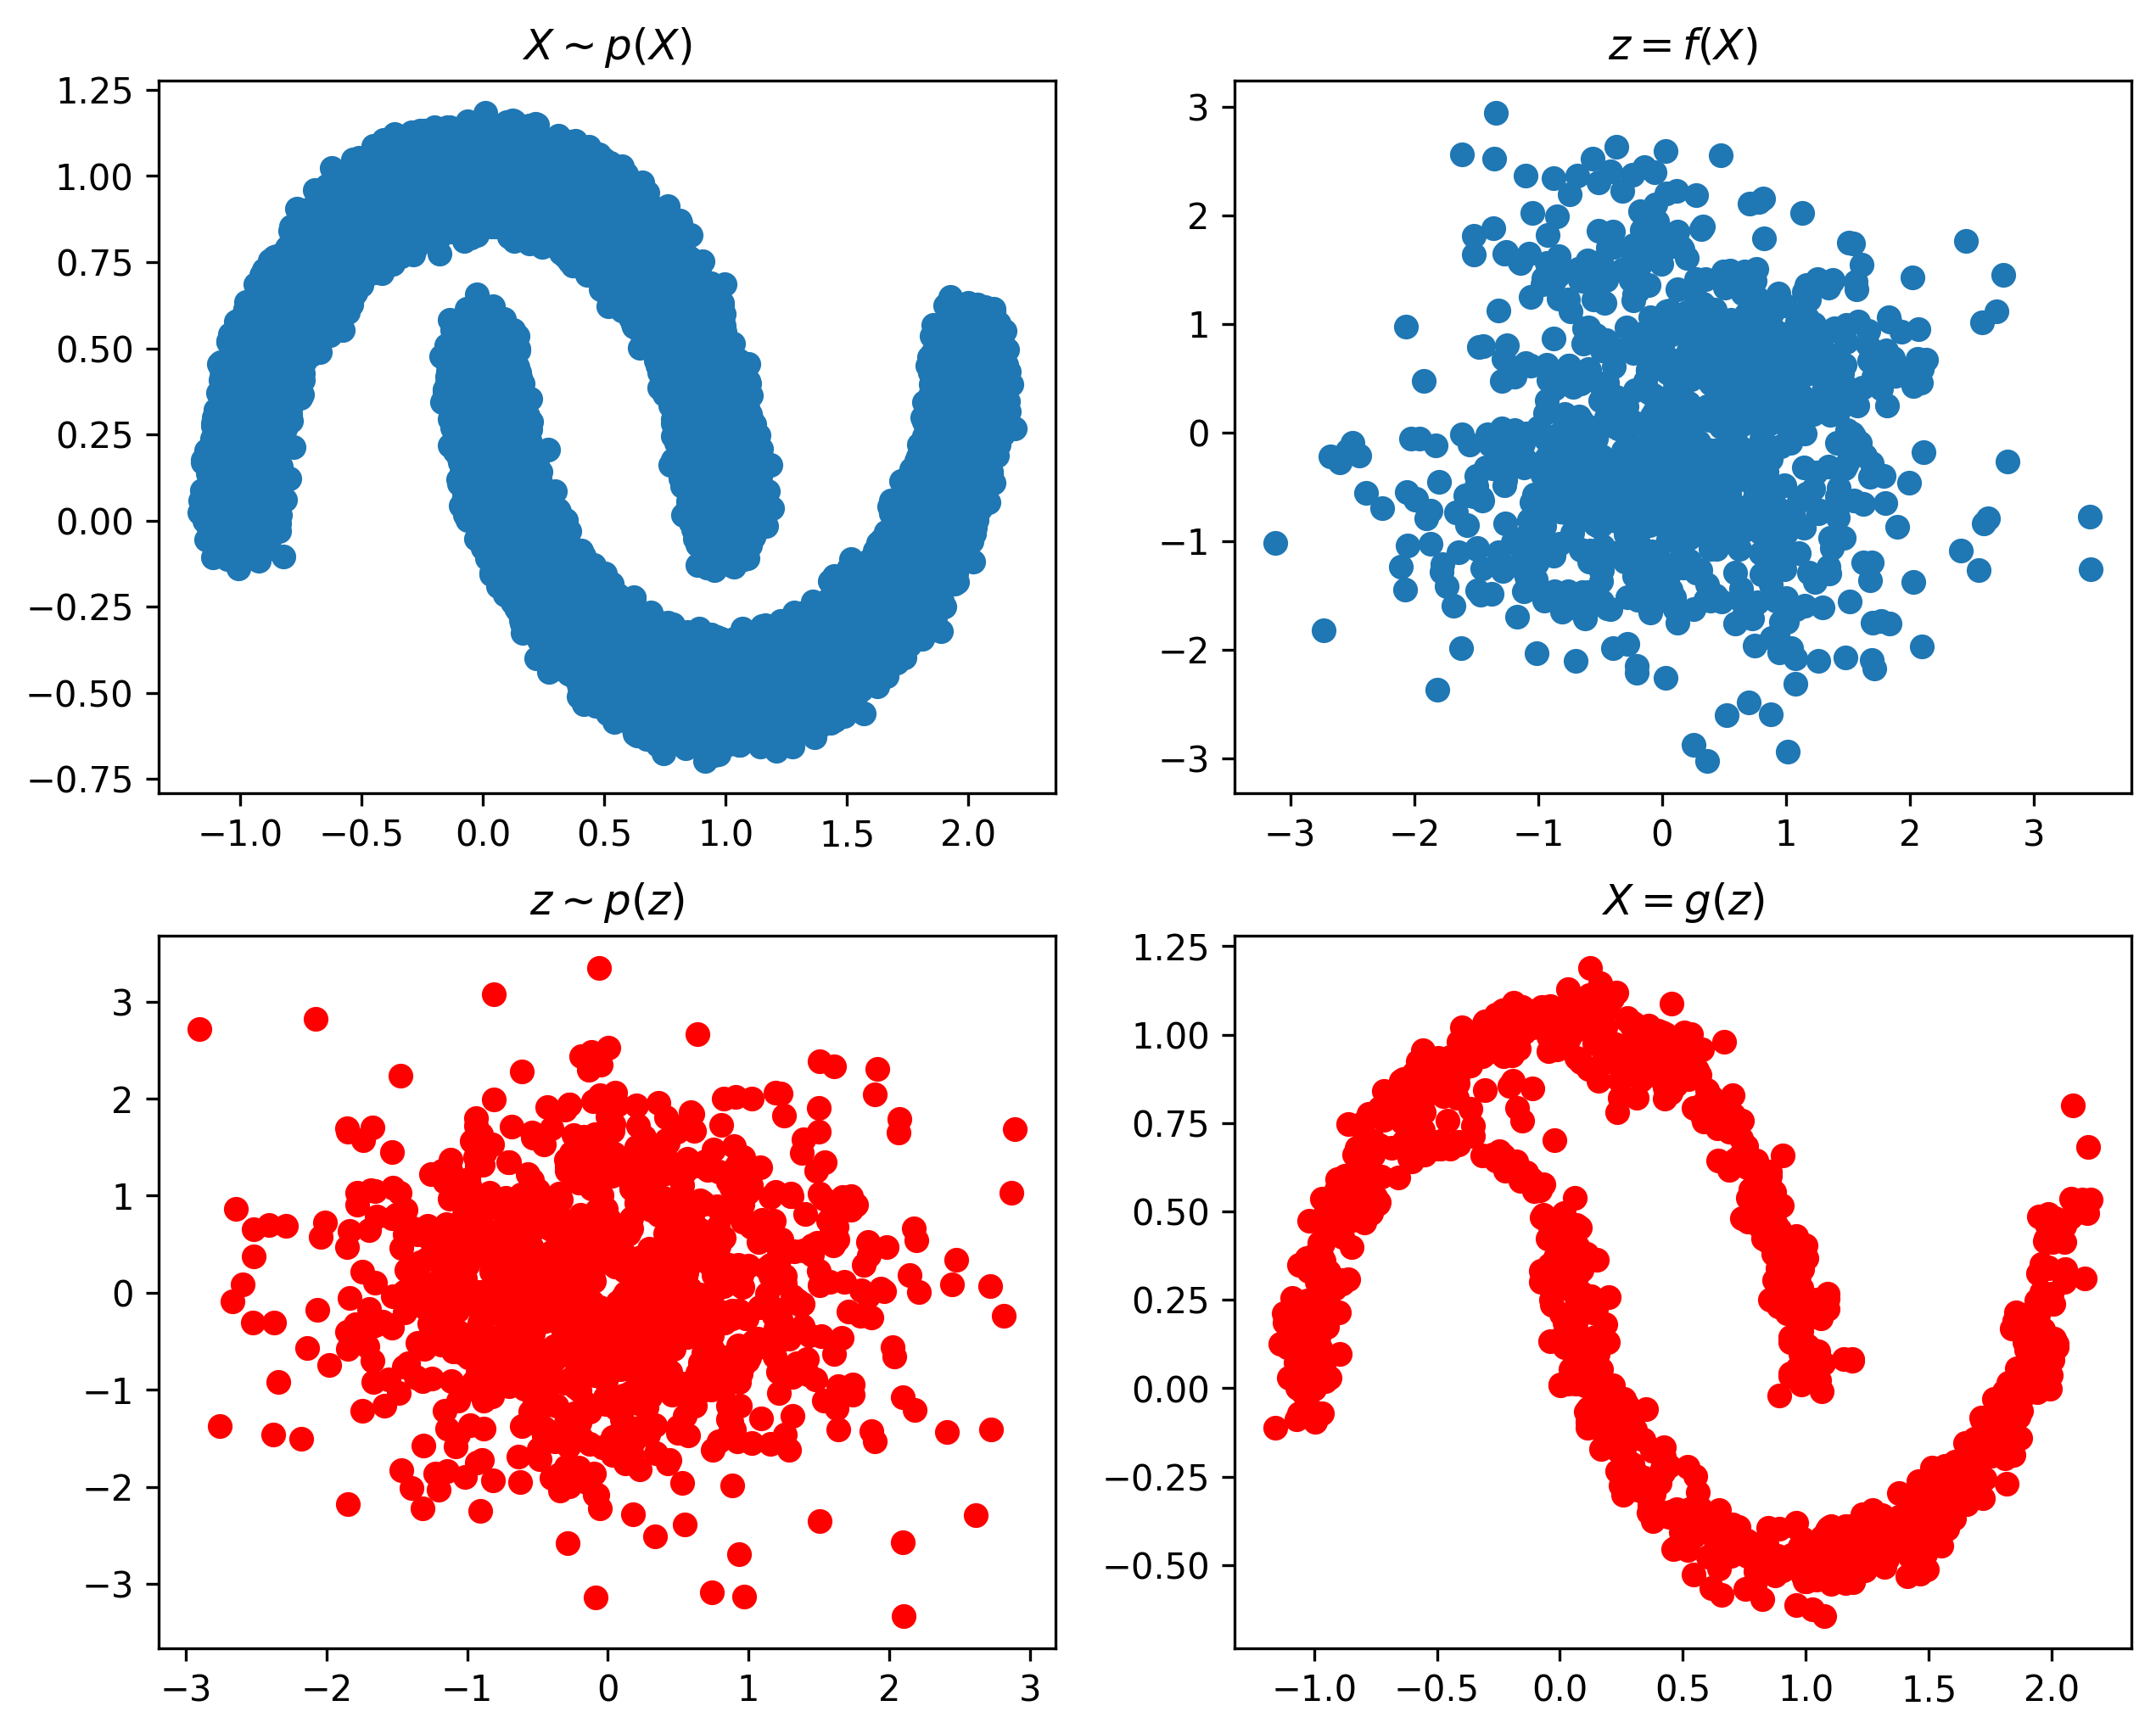

<Figure size 3000x2400 with 0 Axes>

In [384]:
plt.subplot(221)
x = train_data.tensor.cpu()
plt.scatter(x[:, 0], x[:, 1])
plt.title(r'$X \sim p(X)$')

z = flow.apply_transformation(test_data.tensor, is_reverse=False)[0].detach().cpu().numpy()
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(223)
plt.scatter(z[:, 0], z[:, 1], c='r')
plt.title(r'$z \sim p(z)$')

plt.subplot(224)
x = flow.sample(1000).detach().cpu().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')
plt.show()
plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_data, test_data, and flow are already defined and available

plt.figure(figsize=(10, 10))

# Original data distribution as a heatmap
plt.subplot(221)
x = train_data.tensor.cpu().numpy()
plt.hist2d(x[:, 0], x[:, 1], bins=30, cmap='viridis')
plt.colorbar()
plt.title(r'$X \sim p(X)$')

# Transformed test data distribution as a heatmap
plt.subplot(222)
z = flow.apply_transformation(test_data.tensor, is_reverse=False)[0].detach().cpu().numpy()
plt.hist2d(z[:, 0], z[:, 1], bins=30, cmap='viridis')
plt.colorbar()
plt.title(r'$z = f(X)$')

# Random samples from a multivariate normal distribution as a heatmap
plt.subplot(223)
z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.hist2d(z[:, 0], z[:, 1], bins=30, cmap='viridis', cmin=1)
plt.colorbar()
plt.title(r'$z \sim p(z)$')

# Samples from the model as a heatmap
plt.subplot(224)
x = flow.sample(1000).detach().cpu().numpy()
plt.hist2d(x[:, 0, 0], x[:, 0, 1], bins=30, cmap='viridis', cmin=1)
plt.colorbar()
plt.title(r'$X = g(z)$')

plt.tight_layout()
plt.show()

In [295]:
train_data_circles = NumpyDataset(datasets.make_circles(10000, factor=0.8, noise=0.15, shuffle=True)[0].astype(np.float32))
test_data_circles = NumpyDataset(datasets.make_circles(1000, factor=0.8, noise=0.15, shuffle=True)[0].astype(np.float32))

train_loader_circles = data.DataLoader(train_data_circles, batch_size=64, shuffle=False)
test_loader_circles = data.DataLoader(test_data_circles, batch_size=64)

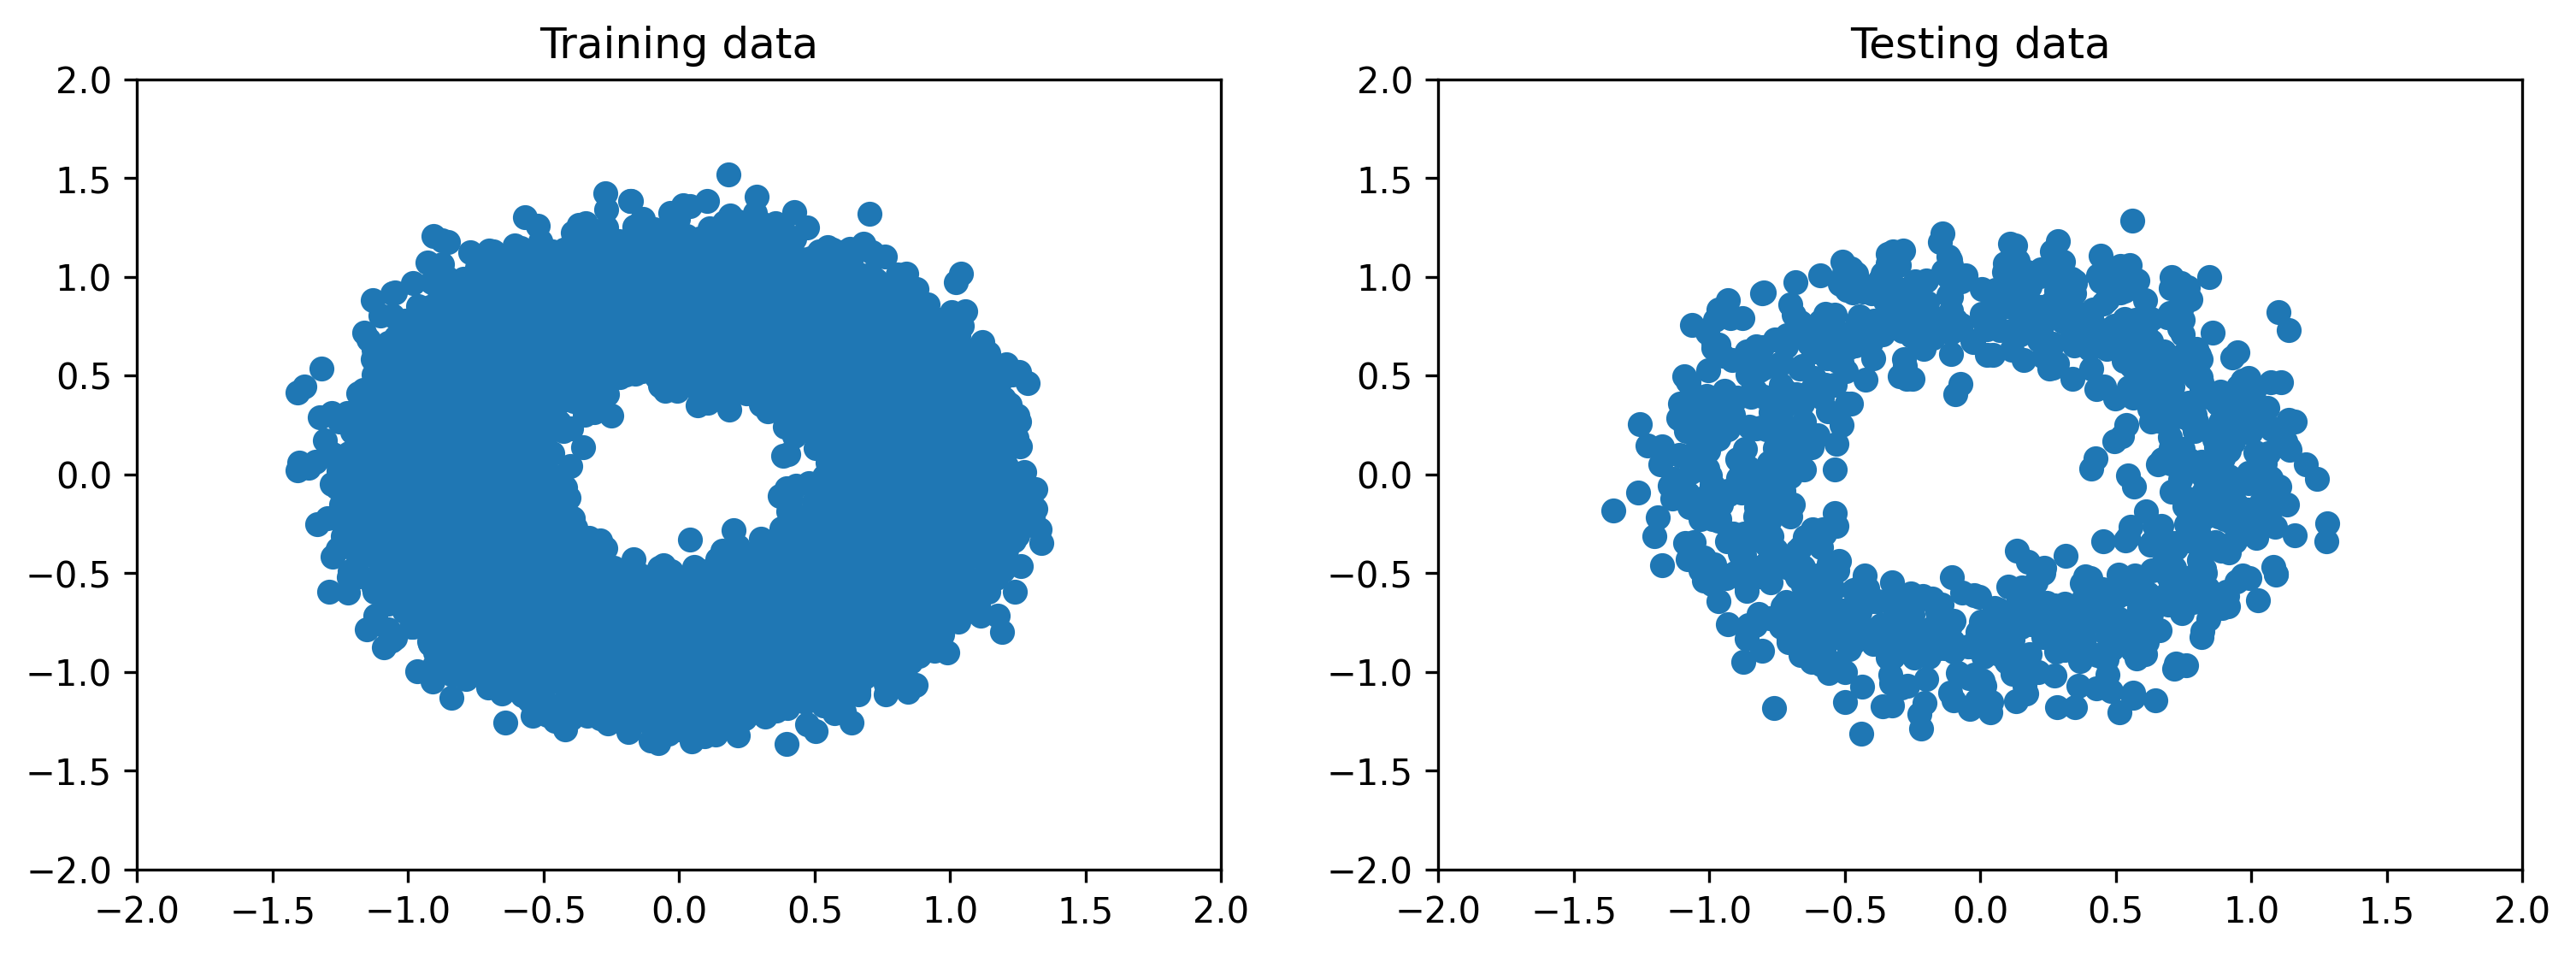

In [296]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].scatter(train_data_circles.tensor[:][:,0].cpu(), train_data_circles.tensor[:][:,1].cpu())
axes[0].set(xlim=(-2, 2), ylim=(-2, 2))
_ = axes[0].set_title('Training data')

axes[1].scatter(test_data_circles.tensor[:][:,0].cpu(), test_data_circles.tensor[:][:,1].cpu())
axes[1].set(xlim=(-2, 2), ylim=(-2, 2))
_ = axes[1].set_title('Testing data')

plt.show()

In [299]:
n_epochs = 1000
mask = torch.nn.functional.one_hot(torch.tensor([i % 2 for i in range(4)])).float()
learning_rate = 1e-4
flow2 = RealNVP(learning_rate=learning_rate, device='cuda', dataset_name="Circles", masks=mask)
flow2.fit(train_loader_circles, n_epochs, restore_best=False)

Epoch 0, Loss: 1.8058781623840332
Epoch 10, Loss: 1.4691797494888306
Epoch 20, Loss: 1.4405462741851807
Epoch 30, Loss: 1.4225760698318481
Epoch 40, Loss: 1.3971372842788696
Epoch 50, Loss: 1.375732660293579
Epoch 60, Loss: 1.3640117645263672
Epoch 70, Loss: 1.3480072021484375
Epoch 80, Loss: 1.3402600288391113
Epoch 90, Loss: 1.3368396759033203
Epoch 100, Loss: 1.3360646963119507
Epoch 110, Loss: 1.3327887058258057
Epoch 120, Loss: 1.325304627418518
Epoch 130, Loss: 1.3287265300750732
Epoch 140, Loss: 1.3291571140289307
Epoch 150, Loss: 1.3330955505371094
Epoch 160, Loss: 1.3341255187988281
Epoch 170, Loss: 1.334456443786621
Epoch 180, Loss: 1.3360300064086914
Epoch 190, Loss: 1.3380227088928223
Epoch 200, Loss: 1.3392436504364014
Epoch 210, Loss: 1.3391201496124268
Epoch 220, Loss: 1.3416779041290283
Epoch 230, Loss: 1.343367099761963
Epoch 240, Loss: 1.3431570529937744
Epoch 250, Loss: 1.3452377319335938
Epoch 260, Loss: 1.3439322710037231
Epoch 270, Loss: 1.3441879749298096
Epoch 2

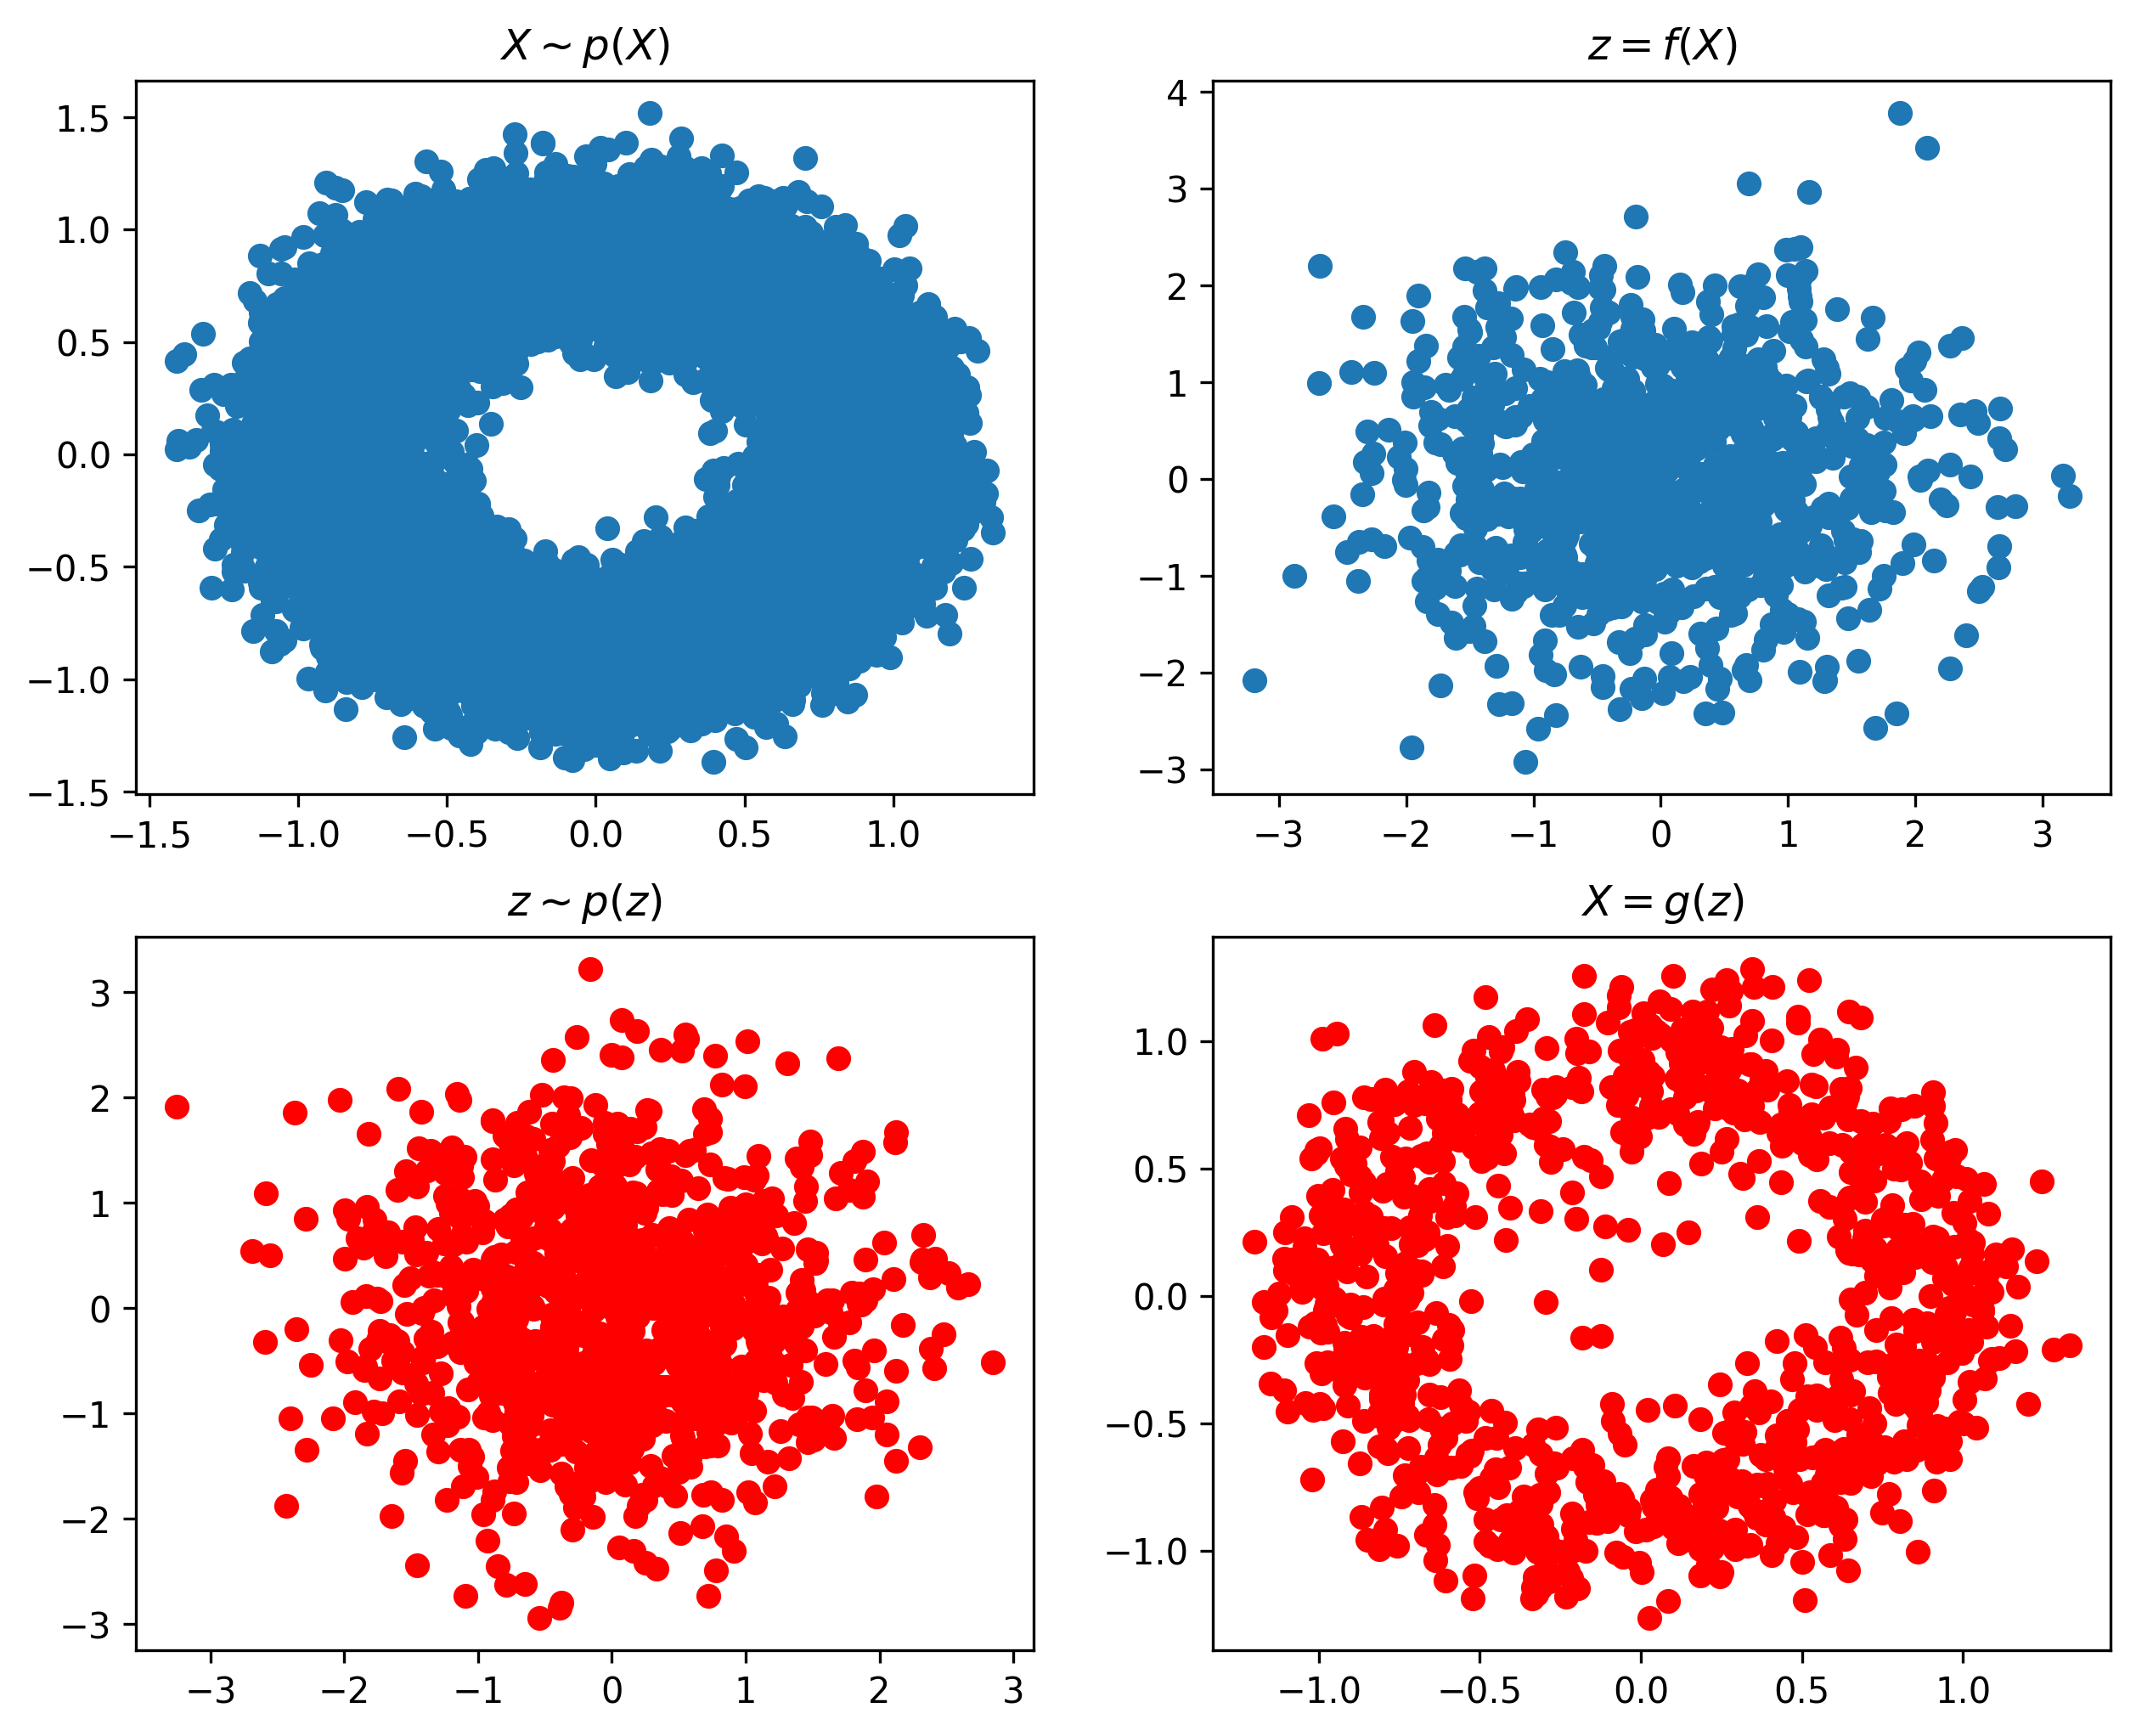

<Figure size 3000x2400 with 0 Axes>

In [300]:
plt.subplot(221)
x = train_data_circles.tensor.cpu()
plt.scatter(x[:, 0], x[:, 1])
plt.title(r'$X \sim p(X)$')

z = flow2.apply_transformation(test_data_circles.tensor, is_reverse=False)[0].detach().cpu().numpy()
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(223)
plt.scatter(z[:, 0], z[:, 1], c='r')
plt.title(r'$z \sim p(z)$')

plt.subplot(224)
x = flow2.sample(1000).detach().cpu().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')
plt.show()
plt.tight_layout()

In [312]:
# Inspired from https://github.com/AxelNathanson/pytorch-normalizing-flows/blob/main/utils.py
def make_art_gaussian(n_gaussians=3, n_samples=1000):
    radius = 2.5
    angles = np.linspace(0, 2 * np.pi, n_gaussians, endpoint=False)

    cov = np.array([[.1, 0], [0, .1]])
    results = []

    for angle in angles:
        results.append(
            np.random.multivariate_normal(radius * np.array([np.cos(angle), np.sin(angle)]), cov,
                                          int(n_samples / 3) + 1))

    return np.random.permutation(np.concatenate(results))

In [385]:
train_data_gaussian = NumpyDataset(make_art_gaussian(n_gaussians=4, n_samples=7000).astype(np.float32))
test_data_gaussian = NumpyDataset(make_art_gaussian(n_gaussians=4, n_samples=3000).astype(np.float32))

train_loader_gaussian = data.DataLoader(train_data_gaussian, batch_size=64, shuffle=False)
test_loader_gaussian = data.DataLoader(test_data_gaussian, batch_size=64)

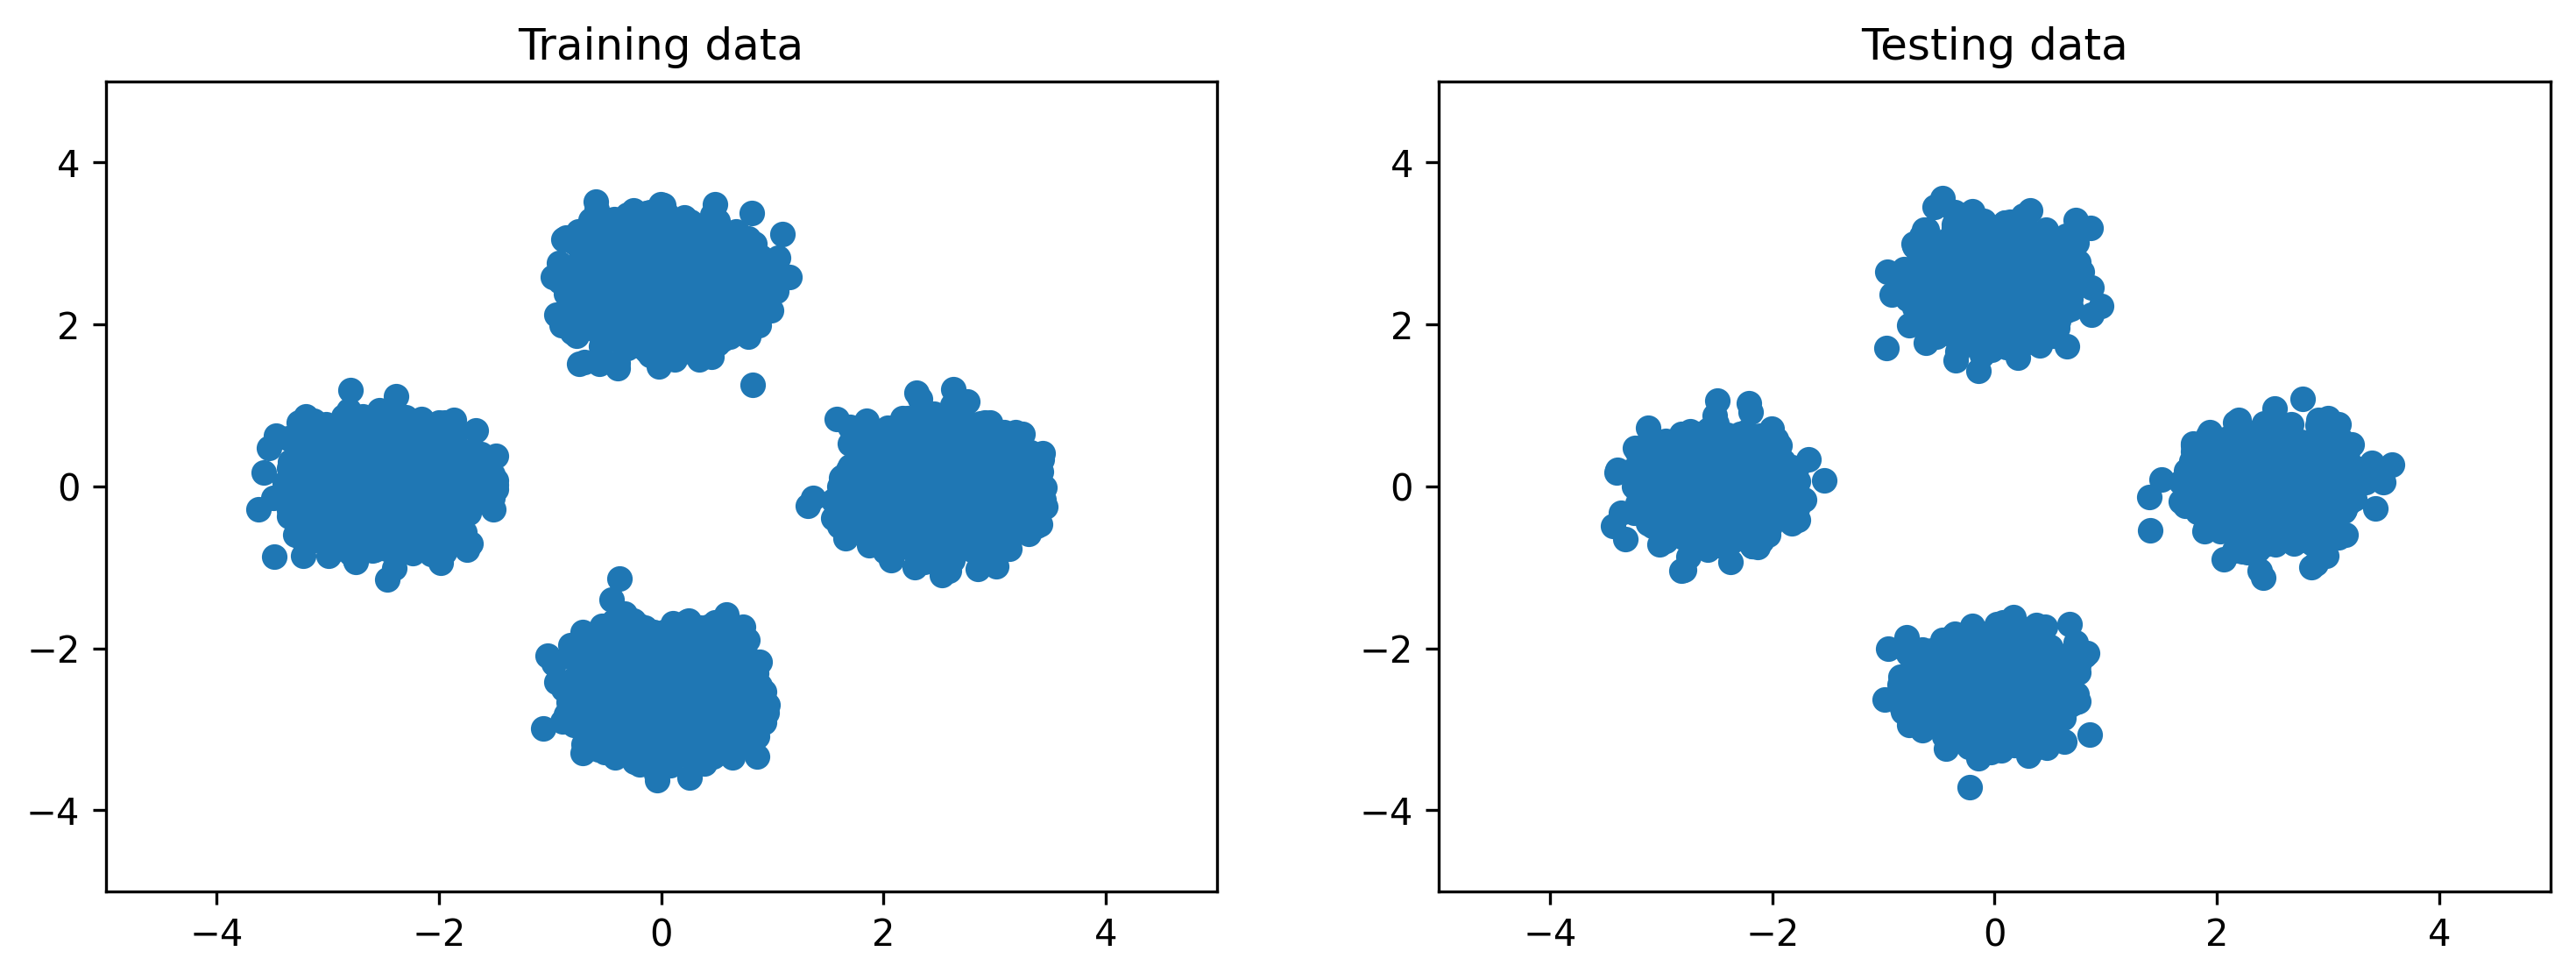

In [314]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].scatter(train_data_gaussian.tensor[:][:,0].cpu(), train_data_gaussian.tensor[:][:,1].cpu())
axes[0].set(xlim=(-5, 5), ylim=(-5, 5))
_ = axes[0].set_title('Training data')

axes[1].scatter(test_data_gaussian.tensor[:][:,0].cpu(), test_data_gaussian.tensor[:][:,1].cpu())
axes[1].set(xlim=(-5, 5), ylim=(-5, 5))
_ = axes[1].set_title('Testing data')

plt.show()

In [387]:
n_epochs = 1000
mask = torch.nn.functional.one_hot(torch.tensor([i % 2 for i in range(4)])).float()
learning_rate = 1e-4
flow3 = RealNVP(learning_rate=learning_rate, device='cuda', dataset_name="Circles", masks=mask)
flow3.fit(train_loader_gaussian, n_epochs, restore_best=False)

Epoch 0, Loss: 3.941678047180176
Epoch 10, Loss: 2.9939589500427246
Epoch 20, Loss: 2.744413375854492
Epoch 30, Loss: 2.5711238384246826
Epoch 40, Loss: 2.503507137298584
Epoch 50, Loss: 2.4430644512176514
Epoch 60, Loss: 2.3996357917785645
Epoch 70, Loss: 2.362091541290283
Epoch 80, Loss: 2.3298730850219727
Epoch 90, Loss: 2.3081777095794678
Epoch 100, Loss: 2.2858548164367676
Epoch 110, Loss: 2.275780439376831
Epoch 120, Loss: 2.2667150497436523
Epoch 130, Loss: 2.259227752685547
Epoch 140, Loss: 2.245591640472412
Epoch 150, Loss: 2.2654683589935303
Epoch 160, Loss: 2.2460556030273438
Epoch 170, Loss: 2.2344837188720703
Epoch 180, Loss: 2.2247469425201416
Epoch 190, Loss: 2.22531795501709
Epoch 200, Loss: 2.2260494232177734
Epoch 210, Loss: 2.21718692779541
Epoch 220, Loss: 2.2171449661254883
Epoch 230, Loss: 2.212787628173828
Epoch 240, Loss: 2.2408337593078613
Epoch 250, Loss: 2.2096028327941895
Epoch 260, Loss: 2.21962833404541
Epoch 270, Loss: 2.2037506103515625
Epoch 280, Loss: 

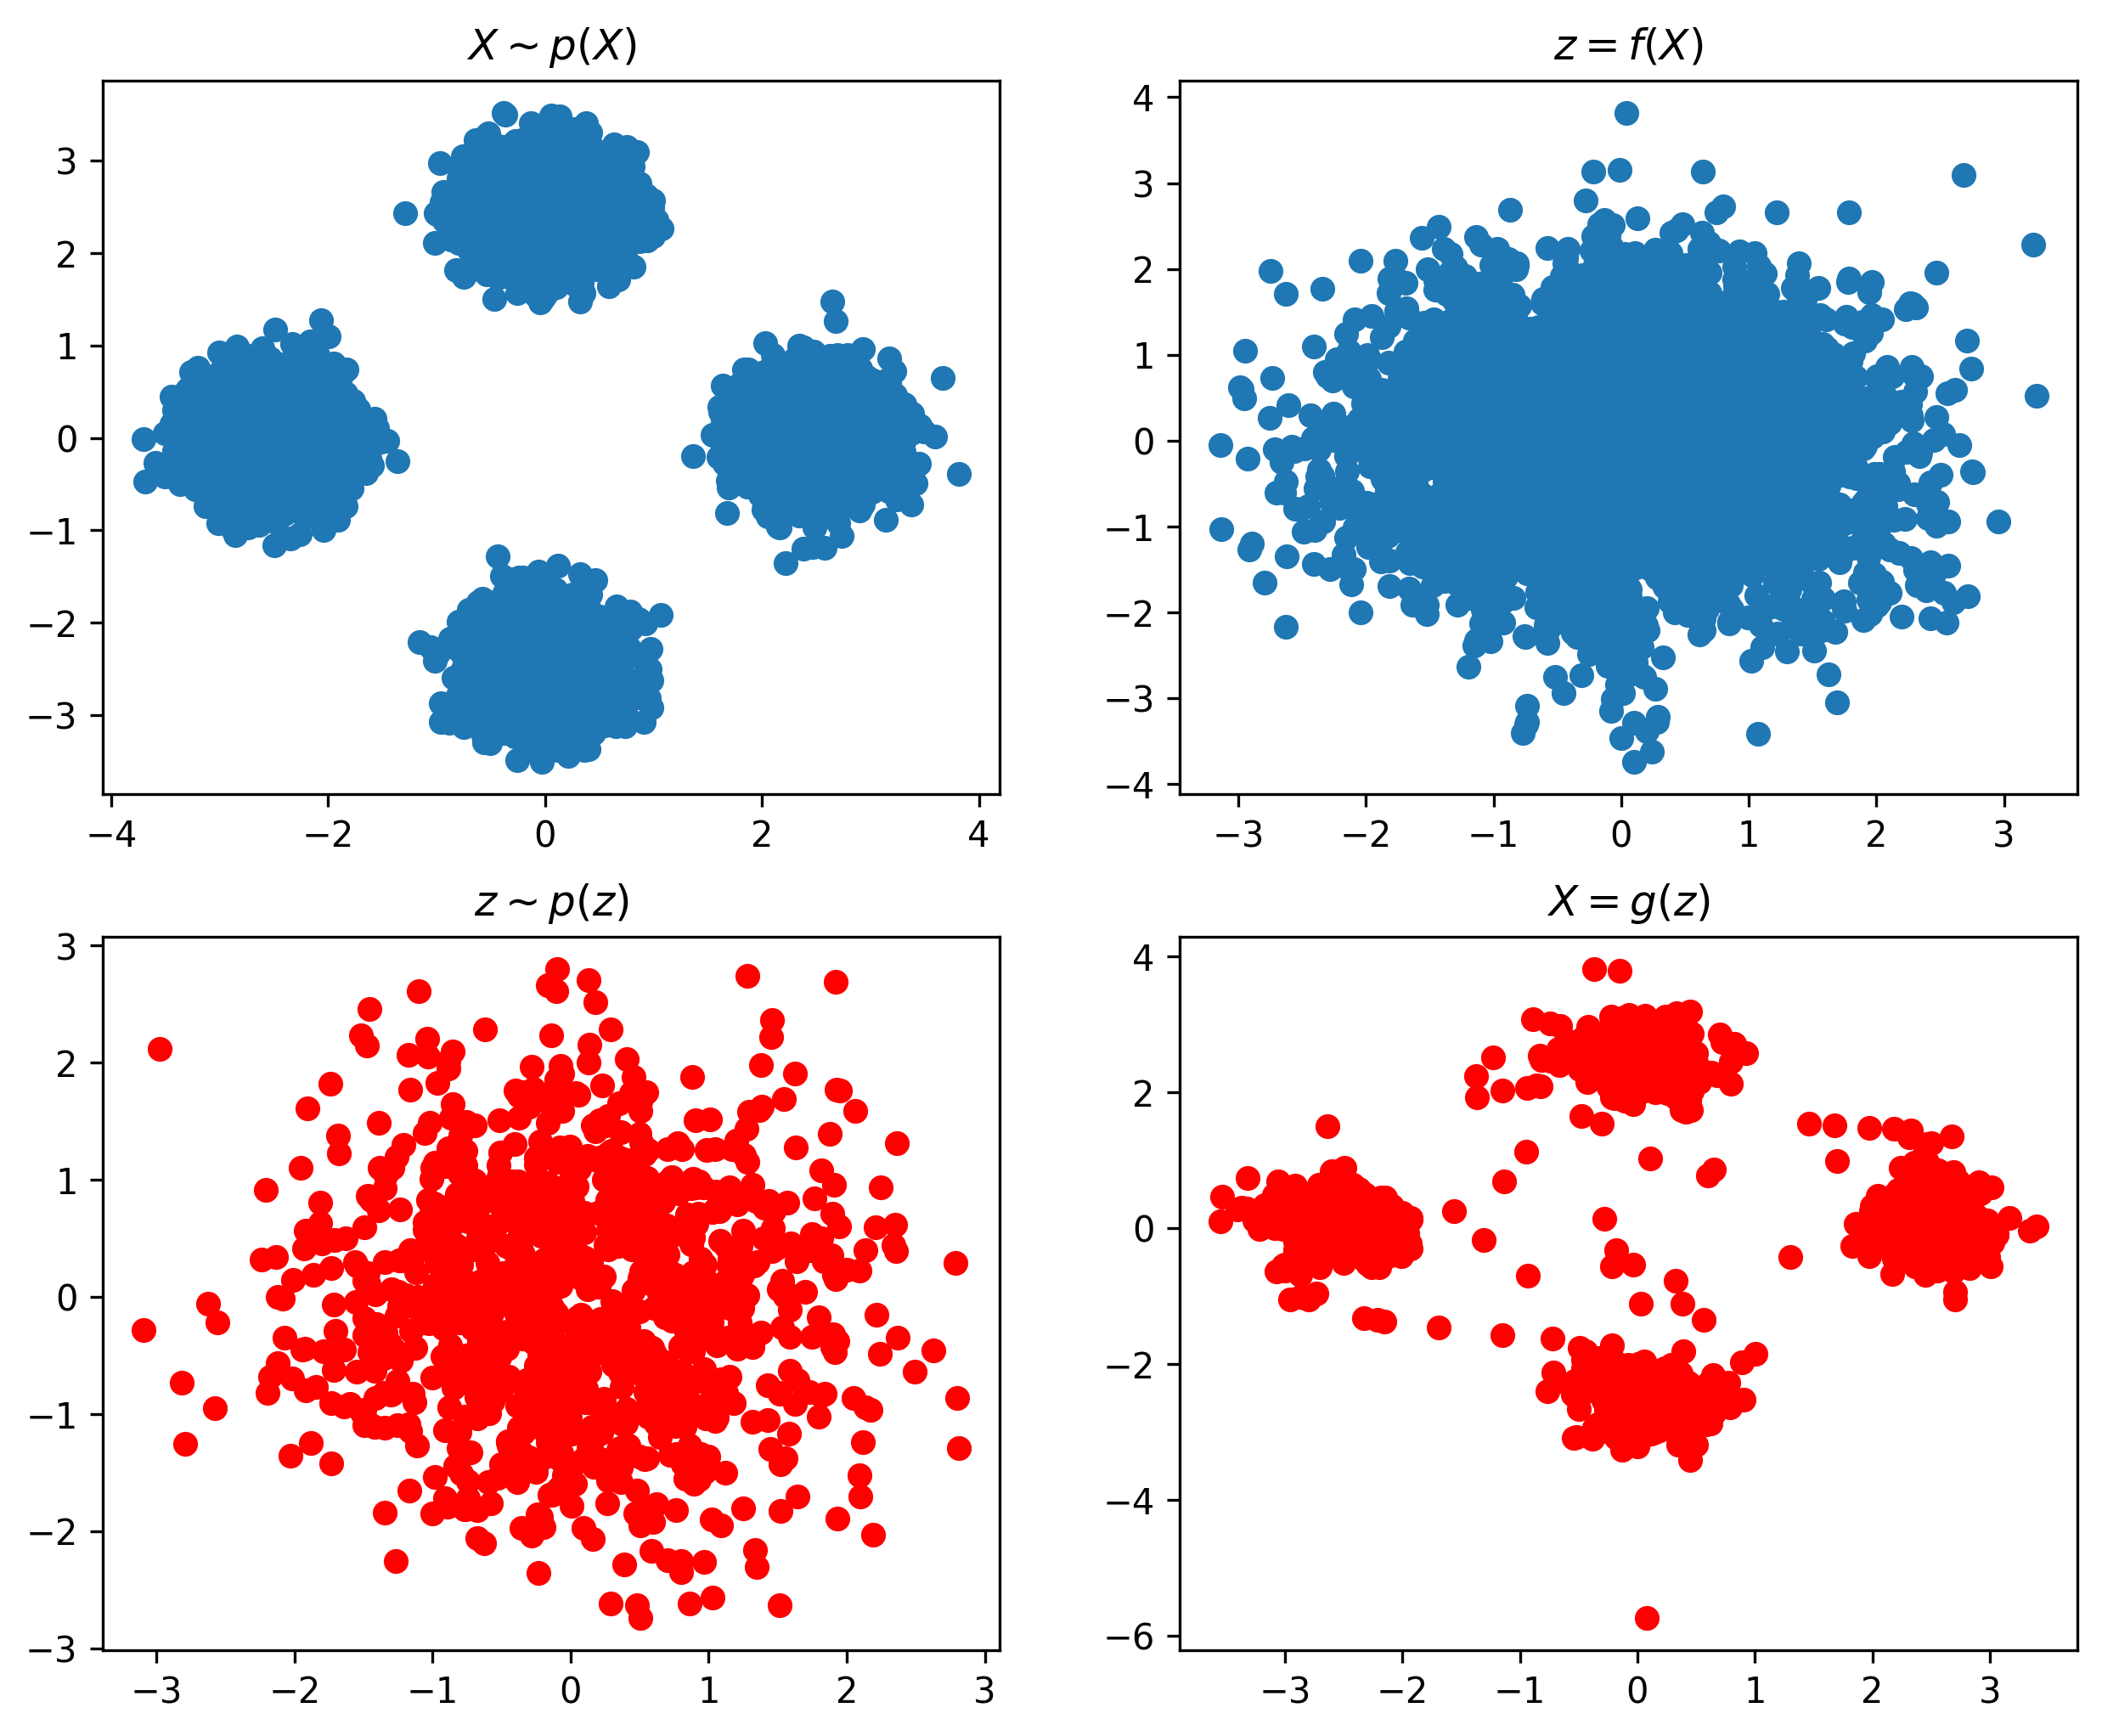

<Figure size 3000x2400 with 0 Axes>

In [389]:
plt.subplot(221)
x = train_data_gaussian.tensor.cpu()
plt.scatter(x[:, 0], x[:, 1])
plt.title(r'$X \sim p(X)$')

z = flow3.apply_transformation(test_data_gaussian.tensor, is_reverse=False)[0].detach().cpu().numpy()
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(223)
plt.scatter(z[:, 0], z[:, 1], c='r')
plt.title(r'$z \sim p(z)$')

plt.subplot(224)
x = flow3.sample(1000).detach().cpu().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')
plt.show()
plt.tight_layout()

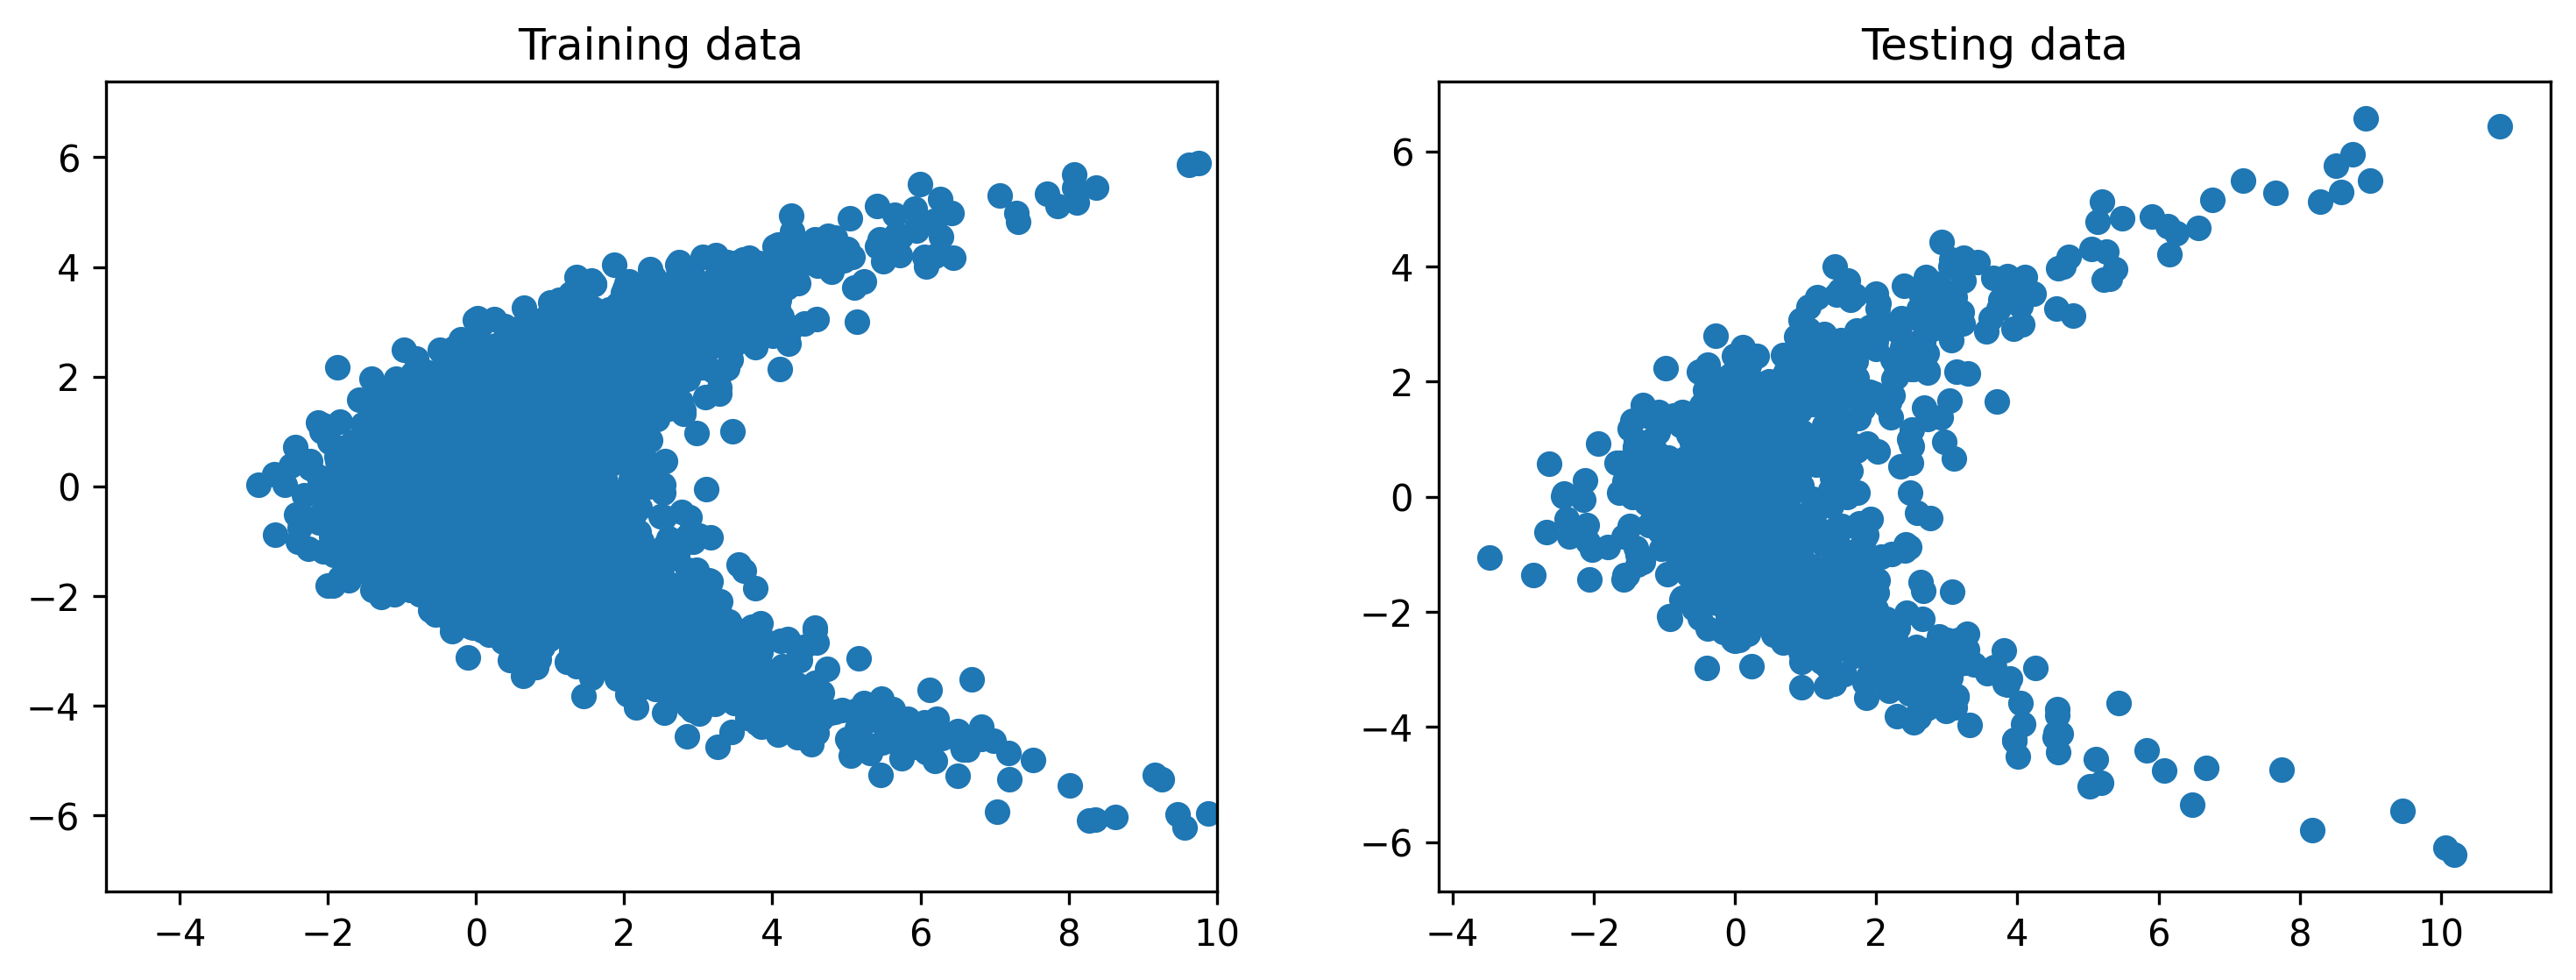

In [440]:
def get_normal_samples(n_samples=1000, std_dev=1.0):
    x2_dist = torch.distributions.Normal(0., std_dev)
    x2_samples = x2_dist.sample((n_samples,))
    x1_dist = torch.distributions.Normal(.25 * x2_samples**2, torch.ones(n_samples))
    x1_samples = x1_dist.sample()
    x_samples = torch.stack([x1_samples, x2_samples], dim=1)
    return x_samples

x_train_samples = get_normal_samples(4000, std_dev=2.0).to(device)
x_test_samples = get_normal_samples(1000, std_dev=2.0).to(device)


fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].scatter(x_train_samples.cpu()[:, 0], x_train_samples.cpu()[:, 1])
axes[0].set(xlim=(-5, 10))
_ = axes[0].set_title('Training data')

axes[1].scatter(x_test_samples.cpu()[:, 0], x_test_samples.cpu()[:, 1])
_ = axes[1].set_title('Testing data')
plt.show()

In [413]:
train_loader_normal = data.DataLoader(x_train_samples, batch_size=64, shuffle=False)
test_loader_normal = data.DataLoader(x_test_samples, batch_size=64)

n_epochs = 1000
mask = torch.nn.functional.one_hot(torch.tensor([i % 2 for i in range(4)])).float()
learning_rate = 1e-4
flow4 = RealNVP(learning_rate=learning_rate, device='cuda', dataset_name="Circles", masks=mask)
flow4.fit(train_loader_normal, n_epochs, restore_best=False)

Epoch 0, Loss: 5.197829246520996
Epoch 10, Loss: 3.8058085441589355
Epoch 20, Loss: 3.7775988578796387
Epoch 30, Loss: 3.7429089546203613
Epoch 40, Loss: 3.7107415199279785
Epoch 50, Loss: 3.695930004119873
Epoch 60, Loss: 3.689429759979248
Epoch 70, Loss: 3.6873526573181152
Epoch 80, Loss: 3.687119722366333
Epoch 90, Loss: 3.686891555786133
Epoch 100, Loss: 3.6871752738952637
Epoch 110, Loss: 3.6871118545532227
Epoch 120, Loss: 3.686835527420044
Epoch 130, Loss: 3.686826229095459
Epoch 140, Loss: 3.686598300933838
Epoch 150, Loss: 3.6864819526672363
Epoch 160, Loss: 3.686478614807129
Epoch 170, Loss: 3.686330795288086
Epoch 180, Loss: 3.685865879058838
Epoch 190, Loss: 3.6851024627685547
Epoch 200, Loss: 3.6843323707580566
Epoch 210, Loss: 3.6836254596710205
Epoch 220, Loss: 3.6832127571105957
Epoch 230, Loss: 3.6823577880859375
Epoch 240, Loss: 3.682002067565918
Epoch 250, Loss: 3.681276798248291
Epoch 260, Loss: 3.680849552154541
Epoch 270, Loss: 3.6802706718444824
Epoch 280, Loss: 

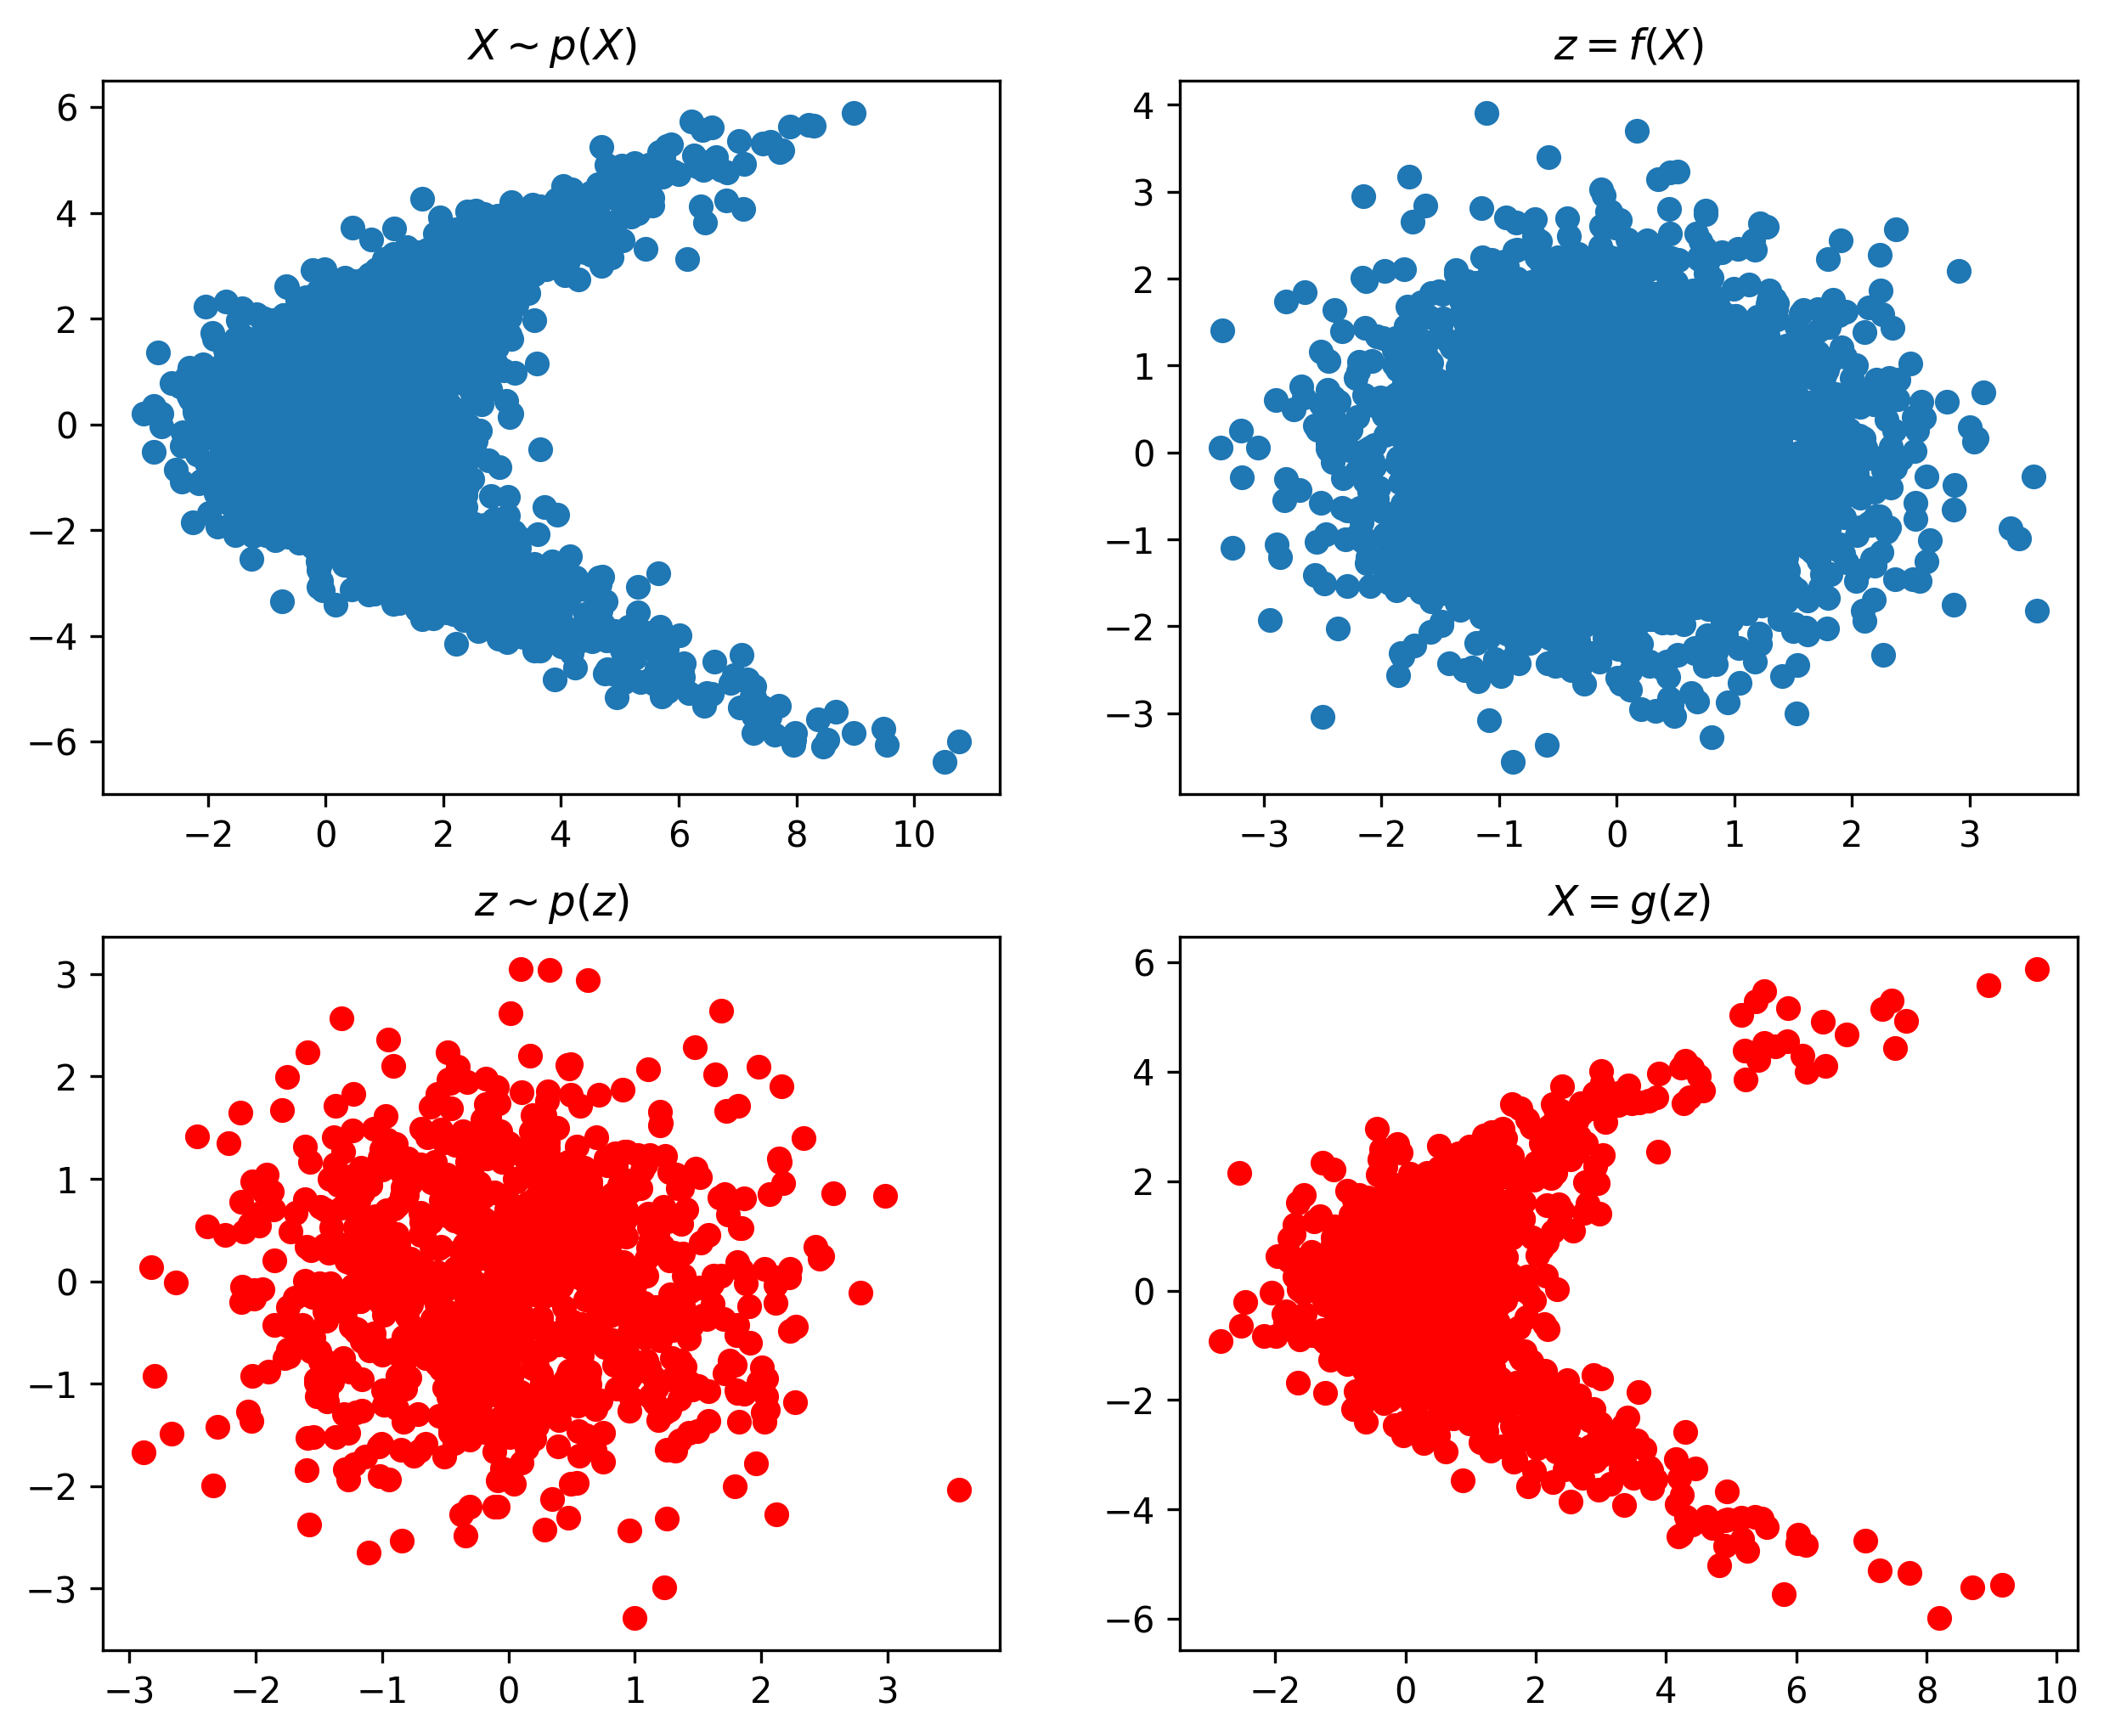

<Figure size 3000x2400 with 0 Axes>

In [426]:
plt.subplot(221)
x = x_train_samples.cpu()
plt.scatter(x[:, 0], x[:, 1])
plt.title(r'$X \sim p(X)$')

z = flow4.apply_transformation(x_train_samples, is_reverse=False)[0].detach().cpu().numpy()
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = flow4.prior.sample((1000,)).detach().cpu().numpy()
plt.subplot(223)
plt.scatter(z[:, 0], z[:, 1], c='r')
plt.title(r'$z \sim p(z)$')

plt.subplot(224)
x = flow4.sample(1000).detach().cpu().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')
plt.show()
plt.tight_layout()